# HW 5 - VAST Challenge Algorithm Selection

I've decided on working on the 2011 VAST challenge. For the purpose of HW5-7 I will be focusing on MC1. Please refer to [this page](http://vast.cs.umass.edu/VAST%20Challenge%202011/challenges/MC1%20-%20Characterization%20of%20an%20Epidemic%20Spread/) for details.

MC1 focuses on twitter data with geo-location information. While placing Tweets on a map is relatively straight-forward, analyzing the text of the tweets is more involved. Part of the challenge is processing the tweets and getting them in a format that can be analyzed. 

To get experience with text processing I will look at a song lyrics [dataset](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics) found on Kaggle (which I will also use during the midterm assignment).

For the purpose of this assignment (and the midterm) I will only be looking at lyrics within the Metal genre. As a former fan of the Metal genre, I will create a list of words that are considered to be "Metal" and judge a song's metalness based on the proportion of "Metal" to non-"Metal" words.

This proportion will be used as the Metalness score and will be fed into a clustering algorithm to cluster songs (and potentially artists, albums, or years) based on metalness. 

The code below does the following:
+ Reads in and parses the data set (filtering for only songs in the Metal genre)
+ Establishes a list of metal words
+ Removes stop words and generates word counts for each song
+ Removes sparse songs (less than 10 words)
+ Scores songs by metalness using total_metal_word_occurances/total_words


In [40]:
import pandas as pd
import re
import nltk
import math
from nltk.corpus import stopwords
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

#Read in data
nltk.download("stopwords")
data = pd.read_csv("data/lyrics.csv")
data.lyrics = data.lyrics.astype(str)

#Define metal words
metal_words = ['fire', 'hell', 'kill', 'slaughter', 'witch', 'scream', 'storm', 'darkness', 'fires', 'demon'
               'demons', 'devil', 'satan', 'mountains', 'hellfire', 'fireball', 'vikings', 'viking', 'ritual']

#Filter out only metal songs
data = data.loc[data.genre == "Metal", :]

#Parse the text, retaining only alphabetic characters and whitespace (new lines replaced with a space)
parse = lambda x : re.sub('[^a-zA-Z\s]', '', x).replace('\n', ' ').lower()

#Apply parsing function
data.lyrics = data.lyrics.apply(parse)

#Count all non-stopwords in a string
def wordcount(x):
    wordcount = {}
    stops = set(stopwords.words("english"))
    words = x.split()
    words = [word for word in words if word not in stops]
    for word in words:
        count = wordcount.get(word, 0)
        count = count + 1
        wordcount[word] = count
    return wordcount

#Create a column with wordcount dictionaries for each song
data["counts"] = data.lyrics.apply(wordcount)

#Create column with total words
data['total_words'] = data.counts.apply(lambda x: sum(x.values()))

#Remove songs with less than 10 words
data = data.loc[data['total_words'] >= 10, :]
data = data.reset_index()

def sorted_wc(temp):
    for w in sorted(temp, key=temp.get, reverse = True):
        print(w, temp[w])

def agg_wc(df):
    agg_count = {}
    for wc in df:
        agg_count.update(wc)
    return agg_count

def metalness(wc, metal_words):
    total_metal_words = 0
    total_words = sum(wc.values())
    for word in metal_words:
        count = wc.get(word, 0)
        total_metal_words += count
    return total_metal_words/total_words

metalness_apply = lambda x: metalness(x, metal_words)

#Establish metalness of each song
data['metalness'] = data['counts'].apply(metalness_apply)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mm80739/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
#Cluster songs based on metalness
clust_model = AgglomerativeClustering(n_clusters=4)
data['labels'] = pd.DataFrame(clust_model.fit_predict(data['metalness'].as_matrix().reshape(-1, 1)))

In [42]:
#Create a ultilty function for plotting metalness by artist
def plot_metalness_year(data, band_name):
    plt.scatter(data['year'], data['metalness'], c = data['labels'])
    plt.xlabel("Year")
    plt.ylabel("Metalness")
    plt.title("Metalness by Year, clustered, "+band_name)
    plt.show()

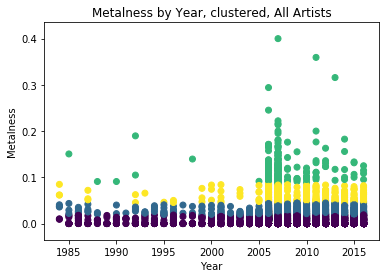

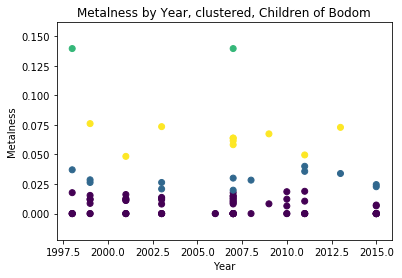

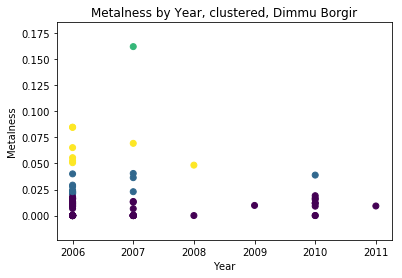

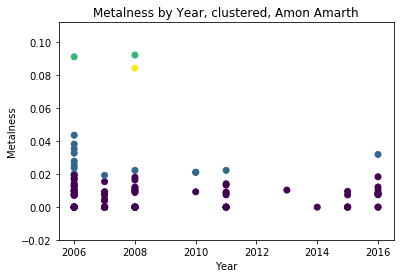

In [43]:
plot_metalness_year(data, "All Artists")
plot_metalness_year(data.loc[data.artist == 'children-of-bodom', :], "Children of Bodom")
plot_metalness_year(data.loc[data.artist == 'dimmu-borgir', :], "Dimmu Borgir")
plot_metalness_year(data.loc[data.artist == 'amon-amarth', :], "Amon Amarth")

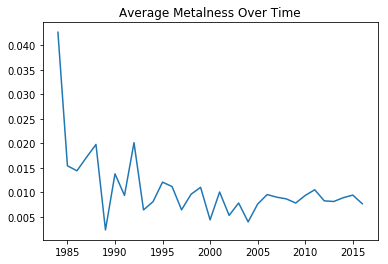

In [44]:
#Display avg Metalness over time
metal_year_mean = data.groupby('year')['metalness'].agg(['mean'])
plt.plot(metal_year_mean.index, metal_year_mean['mean'])
plt.title("Average Metalness Over Time")
plt.show()

# Algorithms and Visualizations for VAST 2011 MC1

The NLP and clustering algorithm used above proved suitable for this analysis. A same set of algorithms could be used on the epidemic twitter data in a similar fasion. Instead of a metalness word list I could create a list of words associated with sickness/epidemic and rate a tweet based on epidemic relevance. A clustering algorithm could then be applied to place tweets into discrete groups.

With these groups, you could plots the tweets on a map (using the provided geo-coding data) and see the affected areas. Adding an interactive sliders for date & time could allow you to see where the epidemic originated and how it spreads over time.